In [1]:
import torch
import torch.nn as nn
# import torch.optibm as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from dataset_class import PatchShuffled_CIFAR10
from matplotlib import pyplot as plt
import argparse
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
batch_size = 128
learning_rate = 1e-4
l2_regularization = 0.0
transform = transforms.Compose([
        transforms.ToTensor()])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mean = np.mean(trainset.data, axis=(0,1,2)) / 255.0  # Compute mean across all images and channels
std = np.std(trainset.data, axis=(0,1,2)) / 255.0  # Compute std across all images and channels



Files already downloaded and verified


In [2]:
data = [[1.0, 2.0], [3.0, 4.0]]
x = torch.tensor(data)
data = [[6.0,7.0], [8.0,9.0]]
y = torch.tensor(data)

print(x)
print(y)

tensor([[1., 2.],
        [3., 4.]])
tensor([[6., 7.],
        [8., 9.]])


In [3]:
a = torch.stack((x, y, ), 1)
a.shape

torch.Size([2, 2, 2])

In [4]:
a

tensor([[[1., 2.],
         [6., 7.]],

        [[3., 4.],
         [8., 9.]]])

In [5]:
torch.mean(a, dim=1)

tensor([[3.5000, 4.5000],
        [5.5000, 6.5000]])

In [6]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize(mean, std)  # Normalize the tensor
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(0))

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
import torch.nn.functional as F

def img_to_patch(x, patch_size, flatten_channels=False):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], CIFAR10 [B, 3, 32, 32]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], CIFAR10 [B, 3, 4, 8, 4, 8]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], CIFAR10 [B, 4, 4, 1, 8, 8]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], CIFAR10 [B, 16, 3, 8, 8]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], CIFAR10 [B, 16, 192]
    return x

class PatchCNN(nn.Module):
    def __init__(self, out_1, out_2, out_3):
        super(PatchCNN, self).__init__()
        # Define the convolutional layers for each patch
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, padding=2)
        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        p=0.5
        self.fc1 = nn.Linear(out_3 * 4, 1000) 
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        
        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)
        

        # torch.Size([128, 3, 32, 32])
    def forward(self, x):
        # print(x.shape)
        # Apply convolution and pooling for each patch
        x = img_to_patch(x, 16)    
        # print(x.shape)
        # print('adfsd')
        patch_features = []

        for i in range(x.shape[1]):
            patch = x[:,i,:,:]
            # print(patch.shape)
            # print('a')
            patch = self.conv1(patch)
            patch = self.conv1_bn(patch)
            patch = self.maxpool1(patch)
            patch = self.drop_conv(patch)
            
            patch = self.conv2(patch)
            patch = self.conv2_bn(patch)
            patch = torch.relu(patch)
            patch = self.maxpool2(patch)
            patch = self.drop_conv(patch)
            
            patch = self.conv3(patch)
            patch = self.conv3_bn(patch)
            patch = torch.relu(patch)
            patch = self.maxpool3(patch)
            patch = self.drop_conv(patch)
            # print(f'last patch shape: {patch.shape}')
            patch = torch.flatten(patch, 1)
            # print(f'last flatten patch shape: {patch.shape}')
            patch_features.append(patch)
            # print(f'patch shape: {patch.shape}')
            # print('______________________________')
        
        patch_features = torch.stack(patch_features, dim=1)
        x = torch.mean(patch_features, dim=1)
        # print(f'x shape: {x.shape}')

        x = self.fc1(x)
        x = self.fc1_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)
        return x

In [17]:
model = PatchCNN(64,128,512)
dummy_input = torch.randn(128, 3, 32, 32)  # Example input tensor (batch size 128)
output = model(dummy_input)
print("Output shape:", output.shape)

Output shape: torch.Size([128, 10])


In [20]:
import torch.optim as optim

# model  = PatchCNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# model.to(device)


model = PatchCNN(out_1=64, out_2=128, out_3 =512)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2)
model.to(device)


PatchCNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_conv): Dropout(p=0.2, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, af

In [21]:
epochs = 100
model_class = 'Plain-Old-CIFAR10'
batch_size = 512
learning_rate = 1e-4
l2_regularization = 0.0
from tqdm import tqdm
best_acc = 0
best_model = None
# model = model_ViT
def eval_model(model, data_loader, criterion, device):
    # Evaluate the model on data from valloader
    correct = 0
    total = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    return val_loss / len(data_loader), 100 * correct / len(data_loader.dataset)

loss_train_list = []
loss_val_list= []
try:
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        model.train()
        for data in tqdm(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        # scheduler.step()
        # if epoch % 10 == 0:
        val_loss, val_acc = eval_model(model, valloader, criterion, device)
        print('epoch - %d loss: %.3f accuracy: %.3f val_loss: %.3f val_acc: %.3f' % (epoch, running_loss / len(trainloader), 100 * correct / len(trainloader.dataset), val_loss, val_acc))
        loss_train_list.append((running_loss / len(trainloader)))
        loss_val_list.append(val_loss)
        if best_acc<val_acc:
            best_model = model.state_dict()
            best_acc = val_acc
            print(f'best acc: {val_acc}')
        # else:
        #     print('epoch - %d loss: %.3f accuracy: %.3f' % (epoch, running_loss / len(trainloader), 100 * correct / len(trainloader.dataset)))


    print('Finished training')
except KeyboardInterrupt:
    pass

100%|██████████| 313/313 [00:27<00:00, 11.41it/s]


epoch - 0 loss: 1.826 accuracy: 31.628 val_loss: 1.798 val_acc: 37.100
best acc: 37.1


100%|██████████| 313/313 [00:27<00:00, 11.21it/s]


epoch - 1 loss: 1.555 accuracy: 42.385 val_loss: 1.684 val_acc: 39.940
best acc: 39.94


100%|██████████| 313/313 [00:27<00:00, 11.25it/s]


epoch - 2 loss: 1.415 accuracy: 48.153 val_loss: 1.528 val_acc: 43.580
best acc: 43.58


100%|██████████| 313/313 [00:28<00:00, 10.85it/s]


epoch - 3 loss: 1.312 accuracy: 52.510 val_loss: 1.521 val_acc: 46.000
best acc: 46.0


100%|██████████| 313/313 [00:29<00:00, 10.56it/s]


epoch - 4 loss: 1.238 accuracy: 55.430 val_loss: 1.372 val_acc: 51.640
best acc: 51.64


100%|██████████| 313/313 [00:31<00:00,  9.86it/s]


epoch - 5 loss: 1.170 accuracy: 58.085 val_loss: 1.274 val_acc: 55.160
best acc: 55.16


100%|██████████| 313/313 [00:30<00:00, 10.13it/s]


epoch - 6 loss: 1.122 accuracy: 60.112 val_loss: 1.361 val_acc: 51.750


100%|██████████| 313/313 [00:31<00:00,  9.91it/s]


epoch - 7 loss: 1.078 accuracy: 61.700 val_loss: 1.409 val_acc: 53.620


100%|██████████| 313/313 [00:31<00:00, 10.04it/s]


epoch - 8 loss: 1.032 accuracy: 63.163 val_loss: 1.202 val_acc: 57.720
best acc: 57.72


100%|██████████| 313/313 [00:31<00:00, 10.08it/s]


epoch - 9 loss: 0.994 accuracy: 64.677 val_loss: 1.121 val_acc: 60.870
best acc: 60.87


100%|██████████| 313/313 [00:31<00:00,  9.98it/s]


epoch - 10 loss: 0.960 accuracy: 65.995 val_loss: 1.156 val_acc: 59.580


100%|██████████| 313/313 [00:30<00:00, 10.21it/s]


epoch - 11 loss: 0.928 accuracy: 67.183 val_loss: 1.229 val_acc: 57.700


100%|██████████| 313/313 [00:30<00:00, 10.34it/s]


epoch - 12 loss: 0.896 accuracy: 68.320 val_loss: 1.038 val_acc: 64.270
best acc: 64.27


100%|██████████| 313/313 [00:31<00:00,  9.94it/s]


epoch - 13 loss: 0.866 accuracy: 69.655 val_loss: 0.945 val_acc: 67.820
best acc: 67.82


100%|██████████| 313/313 [00:31<00:00,  9.81it/s]


epoch - 14 loss: 0.833 accuracy: 70.895 val_loss: 0.996 val_acc: 66.220


100%|██████████| 313/313 [00:31<00:00, 10.08it/s]


epoch - 15 loss: 0.804 accuracy: 71.775 val_loss: 1.113 val_acc: 61.890


100%|██████████| 313/313 [00:31<00:00,  9.89it/s]


epoch - 16 loss: 0.784 accuracy: 72.620 val_loss: 1.008 val_acc: 66.050


100%|██████████| 313/313 [00:30<00:00, 10.32it/s]


epoch - 17 loss: 0.755 accuracy: 73.703 val_loss: 0.958 val_acc: 67.250


100%|██████████| 313/313 [00:31<00:00,  9.97it/s]


epoch - 18 loss: 0.723 accuracy: 74.853 val_loss: 1.106 val_acc: 64.690


100%|██████████| 313/313 [00:31<00:00, 10.02it/s]


epoch - 19 loss: 0.706 accuracy: 75.290 val_loss: 1.232 val_acc: 59.550


100%|██████████| 313/313 [00:29<00:00, 10.44it/s]


epoch - 20 loss: 0.676 accuracy: 76.537 val_loss: 1.032 val_acc: 65.480


100%|██████████| 313/313 [00:30<00:00, 10.14it/s]


epoch - 21 loss: 0.656 accuracy: 77.105 val_loss: 0.961 val_acc: 68.570
best acc: 68.57


100%|██████████| 313/313 [00:28<00:00, 10.87it/s]


epoch - 22 loss: 0.631 accuracy: 78.085 val_loss: 1.166 val_acc: 63.000


100%|██████████| 313/313 [00:28<00:00, 10.87it/s]


epoch - 23 loss: 0.607 accuracy: 78.993 val_loss: 1.002 val_acc: 67.630


100%|██████████| 313/313 [00:30<00:00, 10.21it/s]


epoch - 24 loss: 0.581 accuracy: 79.750 val_loss: 1.000 val_acc: 68.310


100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


epoch - 25 loss: 0.562 accuracy: 80.480 val_loss: 1.226 val_acc: 62.170


100%|██████████| 313/313 [00:27<00:00, 11.31it/s]


epoch - 26 loss: 0.542 accuracy: 81.190 val_loss: 1.075 val_acc: 66.890


100%|██████████| 313/313 [00:26<00:00, 11.60it/s]


epoch - 27 loss: 0.525 accuracy: 81.718 val_loss: 1.043 val_acc: 67.870


100%|██████████| 313/313 [00:29<00:00, 10.61it/s]


epoch - 28 loss: 0.499 accuracy: 82.802 val_loss: 1.274 val_acc: 63.120


100%|██████████| 313/313 [00:28<00:00, 10.92it/s]


epoch - 29 loss: 0.487 accuracy: 83.075 val_loss: 1.259 val_acc: 62.250


100%|██████████| 313/313 [00:27<00:00, 11.34it/s]


epoch - 30 loss: 0.466 accuracy: 84.005 val_loss: 1.310 val_acc: 62.670


100%|██████████| 313/313 [00:30<00:00, 10.35it/s]


epoch - 31 loss: 0.449 accuracy: 84.442 val_loss: 1.209 val_acc: 63.620


100%|██████████| 313/313 [00:30<00:00, 10.17it/s]


epoch - 32 loss: 0.437 accuracy: 84.930 val_loss: 1.314 val_acc: 63.010


100%|██████████| 313/313 [00:30<00:00, 10.16it/s]


epoch - 33 loss: 0.411 accuracy: 85.847 val_loss: 1.048 val_acc: 68.720
best acc: 68.72


100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


epoch - 34 loss: 0.398 accuracy: 86.213 val_loss: 1.104 val_acc: 67.600


100%|██████████| 313/313 [00:29<00:00, 10.68it/s]


epoch - 35 loss: 0.384 accuracy: 86.843 val_loss: 1.043 val_acc: 68.960
best acc: 68.96


100%|██████████| 313/313 [00:30<00:00, 10.11it/s]


epoch - 36 loss: 0.362 accuracy: 87.612 val_loss: 1.077 val_acc: 68.450


100%|██████████| 313/313 [00:31<00:00,  9.94it/s]


epoch - 37 loss: 0.349 accuracy: 87.918 val_loss: 0.997 val_acc: 70.880
best acc: 70.88


100%|██████████| 313/313 [00:30<00:00, 10.22it/s]


epoch - 38 loss: 0.343 accuracy: 88.177 val_loss: 1.094 val_acc: 68.290


100%|██████████| 313/313 [00:31<00:00, 10.01it/s]


epoch - 39 loss: 0.323 accuracy: 88.888 val_loss: 1.041 val_acc: 70.120


100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


epoch - 40 loss: 0.316 accuracy: 89.075 val_loss: 1.149 val_acc: 67.930


100%|██████████| 313/313 [00:30<00:00, 10.39it/s]


epoch - 41 loss: 0.300 accuracy: 89.677 val_loss: 1.346 val_acc: 64.400


100%|██████████| 313/313 [00:29<00:00, 10.51it/s]


epoch - 42 loss: 0.291 accuracy: 90.028 val_loss: 1.075 val_acc: 70.240


100%|██████████| 313/313 [00:30<00:00, 10.36it/s]


epoch - 43 loss: 0.285 accuracy: 90.065 val_loss: 1.044 val_acc: 70.260


100%|██████████| 313/313 [00:29<00:00, 10.51it/s]


epoch - 44 loss: 0.268 accuracy: 90.683 val_loss: 1.092 val_acc: 70.530


100%|██████████| 313/313 [00:29<00:00, 10.79it/s]


epoch - 45 loss: 0.261 accuracy: 91.005 val_loss: 1.147 val_acc: 68.810


100%|██████████| 313/313 [00:29<00:00, 10.66it/s]


epoch - 46 loss: 0.252 accuracy: 91.310 val_loss: 1.150 val_acc: 69.150


100%|██████████| 313/313 [00:29<00:00, 10.77it/s]


epoch - 47 loss: 0.239 accuracy: 91.858 val_loss: 1.146 val_acc: 70.200


100%|██████████| 313/313 [00:29<00:00, 10.46it/s]


epoch - 48 loss: 0.235 accuracy: 92.010 val_loss: 1.086 val_acc: 70.510


100%|██████████| 313/313 [00:29<00:00, 10.54it/s]


epoch - 49 loss: 0.229 accuracy: 92.095 val_loss: 1.165 val_acc: 69.760


100%|██████████| 313/313 [00:29<00:00, 10.72it/s]


epoch - 50 loss: 0.211 accuracy: 92.820 val_loss: 1.220 val_acc: 69.310


100%|██████████| 313/313 [00:30<00:00, 10.20it/s]


epoch - 51 loss: 0.217 accuracy: 92.537 val_loss: 1.016 val_acc: 72.370
best acc: 72.37


100%|██████████| 313/313 [00:30<00:00, 10.38it/s]


epoch - 52 loss: 0.204 accuracy: 93.120 val_loss: 1.137 val_acc: 69.840


100%|██████████| 313/313 [00:29<00:00, 10.71it/s]


epoch - 53 loss: 0.196 accuracy: 93.373 val_loss: 1.067 val_acc: 71.570


100%|██████████| 313/313 [00:29<00:00, 10.51it/s]


epoch - 54 loss: 0.197 accuracy: 93.295 val_loss: 1.274 val_acc: 68.060


100%|██████████| 313/313 [00:29<00:00, 10.77it/s]


epoch - 55 loss: 0.186 accuracy: 93.660 val_loss: 1.200 val_acc: 69.570


100%|██████████| 313/313 [00:26<00:00, 11.72it/s]


epoch - 56 loss: 0.180 accuracy: 93.915 val_loss: 1.157 val_acc: 71.230


100%|██████████| 313/313 [00:27<00:00, 11.28it/s]


epoch - 57 loss: 0.172 accuracy: 94.065 val_loss: 1.157 val_acc: 70.640


100%|██████████| 313/313 [00:25<00:00, 12.38it/s]


epoch - 58 loss: 0.162 accuracy: 94.493 val_loss: 1.268 val_acc: 68.330


100%|██████████| 313/313 [00:28<00:00, 10.94it/s]


epoch - 59 loss: 0.155 accuracy: 94.690 val_loss: 1.156 val_acc: 70.490


100%|██████████| 313/313 [00:27<00:00, 11.50it/s]


epoch - 60 loss: 0.162 accuracy: 94.487 val_loss: 1.171 val_acc: 71.290


100%|██████████| 313/313 [00:29<00:00, 10.65it/s]


epoch - 61 loss: 0.154 accuracy: 94.670 val_loss: 1.188 val_acc: 69.940


100%|██████████| 313/313 [00:29<00:00, 10.58it/s]


epoch - 62 loss: 0.147 accuracy: 95.130 val_loss: 1.147 val_acc: 71.750


100%|██████████| 313/313 [00:26<00:00, 11.67it/s]


epoch - 63 loss: 0.151 accuracy: 94.985 val_loss: 1.262 val_acc: 69.860


100%|██████████| 313/313 [00:25<00:00, 12.09it/s]


epoch - 64 loss: 0.141 accuracy: 95.175 val_loss: 1.191 val_acc: 70.810


100%|██████████| 313/313 [00:27<00:00, 11.27it/s]


epoch - 65 loss: 0.136 accuracy: 95.545 val_loss: 1.458 val_acc: 66.290


100%|██████████| 313/313 [00:28<00:00, 10.83it/s]


epoch - 66 loss: 0.133 accuracy: 95.620 val_loss: 1.119 val_acc: 72.370


100%|██████████| 313/313 [00:30<00:00, 10.11it/s]


epoch - 67 loss: 0.132 accuracy: 95.620 val_loss: 1.177 val_acc: 71.410


100%|██████████| 313/313 [00:29<00:00, 10.55it/s]


epoch - 68 loss: 0.127 accuracy: 95.700 val_loss: 1.142 val_acc: 71.530


100%|██████████| 313/313 [00:30<00:00, 10.34it/s]


epoch - 69 loss: 0.124 accuracy: 95.800 val_loss: 1.153 val_acc: 72.030


100%|██████████| 313/313 [00:29<00:00, 10.46it/s]


epoch - 70 loss: 0.120 accuracy: 95.998 val_loss: 1.197 val_acc: 71.490


100%|██████████| 313/313 [00:31<00:00,  9.99it/s]


epoch - 71 loss: 0.120 accuracy: 95.900 val_loss: 1.173 val_acc: 71.890


100%|██████████| 313/313 [00:31<00:00,  9.98it/s]


epoch - 72 loss: 0.114 accuracy: 96.150 val_loss: 1.139 val_acc: 72.390
best acc: 72.39


100%|██████████| 313/313 [00:31<00:00, 10.00it/s]


epoch - 73 loss: 0.115 accuracy: 96.230 val_loss: 1.235 val_acc: 70.880


100%|██████████| 313/313 [00:29<00:00, 10.53it/s]


epoch - 74 loss: 0.104 accuracy: 96.558 val_loss: 1.183 val_acc: 71.500


100%|██████████| 313/313 [00:29<00:00, 10.46it/s]


epoch - 75 loss: 0.108 accuracy: 96.453 val_loss: 1.238 val_acc: 70.680


100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


epoch - 76 loss: 0.106 accuracy: 96.545 val_loss: 1.213 val_acc: 71.380


100%|██████████| 313/313 [00:29<00:00, 10.54it/s]


epoch - 77 loss: 0.105 accuracy: 96.380 val_loss: 1.252 val_acc: 71.100


100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


epoch - 78 loss: 0.100 accuracy: 96.683 val_loss: 1.162 val_acc: 72.470
best acc: 72.47


100%|██████████| 313/313 [00:30<00:00, 10.31it/s]


epoch - 79 loss: 0.102 accuracy: 96.630 val_loss: 1.186 val_acc: 72.170


100%|██████████| 313/313 [00:30<00:00, 10.40it/s]


epoch - 80 loss: 0.098 accuracy: 96.812 val_loss: 1.176 val_acc: 72.290


100%|██████████| 313/313 [00:30<00:00, 10.39it/s]


epoch - 81 loss: 0.094 accuracy: 96.858 val_loss: 1.223 val_acc: 71.340


100%|██████████| 313/313 [00:31<00:00, 10.04it/s]


epoch - 82 loss: 0.090 accuracy: 97.028 val_loss: 1.209 val_acc: 72.040


100%|██████████| 313/313 [00:28<00:00, 11.00it/s]


epoch - 83 loss: 0.092 accuracy: 97.045 val_loss: 1.203 val_acc: 72.500
best acc: 72.5


100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


epoch - 84 loss: 0.087 accuracy: 97.183 val_loss: 1.308 val_acc: 70.860


100%|██████████| 313/313 [00:30<00:00, 10.15it/s]


epoch - 85 loss: 0.086 accuracy: 97.112 val_loss: 1.155 val_acc: 72.850
best acc: 72.85


100%|██████████| 313/313 [00:30<00:00, 10.29it/s]


epoch - 86 loss: 0.090 accuracy: 96.895 val_loss: 1.230 val_acc: 71.860


100%|██████████| 313/313 [00:28<00:00, 10.83it/s]


epoch - 87 loss: 0.082 accuracy: 97.287 val_loss: 1.303 val_acc: 70.910


100%|██████████| 313/313 [00:29<00:00, 10.78it/s]


epoch - 88 loss: 0.083 accuracy: 97.162 val_loss: 1.228 val_acc: 72.420


100%|██████████| 313/313 [00:29<00:00, 10.71it/s]


epoch - 89 loss: 0.083 accuracy: 97.215 val_loss: 1.238 val_acc: 71.430


100%|██████████| 313/313 [00:30<00:00, 10.39it/s]


epoch - 90 loss: 0.079 accuracy: 97.272 val_loss: 1.194 val_acc: 72.380


100%|██████████| 313/313 [00:31<00:00,  9.91it/s]


epoch - 91 loss: 0.082 accuracy: 97.392 val_loss: 1.436 val_acc: 68.300


100%|██████████| 313/313 [00:31<00:00, 10.07it/s]


epoch - 92 loss: 0.079 accuracy: 97.485 val_loss: 1.249 val_acc: 72.040


100%|██████████| 313/313 [00:31<00:00, 10.06it/s]


epoch - 93 loss: 0.073 accuracy: 97.513 val_loss: 1.214 val_acc: 72.370


100%|██████████| 313/313 [00:31<00:00, 10.05it/s]


epoch - 94 loss: 0.073 accuracy: 97.580 val_loss: 1.279 val_acc: 71.930


100%|██████████| 313/313 [00:31<00:00, 10.02it/s]


epoch - 95 loss: 0.074 accuracy: 97.615 val_loss: 1.193 val_acc: 72.870
best acc: 72.87


100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


epoch - 96 loss: 0.070 accuracy: 97.707 val_loss: 1.278 val_acc: 71.510


100%|██████████| 313/313 [00:30<00:00, 10.12it/s]


epoch - 97 loss: 0.074 accuracy: 97.677 val_loss: 1.193 val_acc: 72.250


100%|██████████| 313/313 [00:31<00:00,  9.96it/s]


epoch - 98 loss: 0.067 accuracy: 97.810 val_loss: 1.323 val_acc: 71.230


100%|██████████| 313/313 [00:30<00:00, 10.17it/s]


epoch - 99 loss: 0.068 accuracy: 97.715 val_loss: 1.257 val_acc: 71.880
Finished training


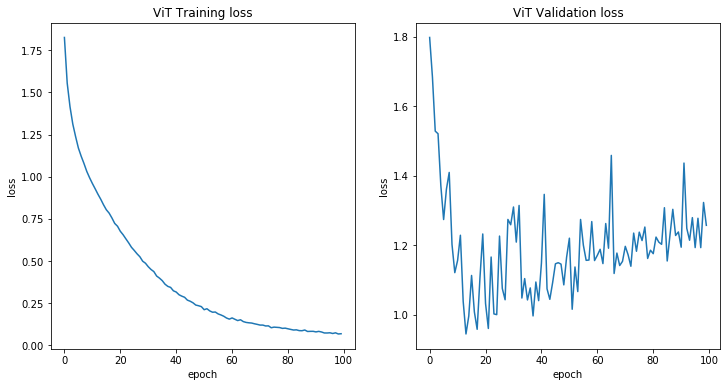

In [22]:
model.load_state_dict(best_model)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('ViT Training loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(loss_val_list)
ax2.set_title('ViT Validation loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
plt.show()

In [23]:
# transform = transforms.Compose([
#         transforms.ToTensor()
#     ])
model.eval()
# Evaluate the model on the test set
test_loss, test_acc = eval_model(model, testloader, criterion, device)
print('Test loss: %.3f accuracy: %.3f' % (test_loss, test_acc))

Test loss: 1.237 accuracy: 72.680


In [24]:
from dataset_class import PatchShuffled_CIFAR10

patch_size = 16
patch_shuffle_testset = PatchShuffled_CIFAR10(data_file_path = f'test_patch_{patch_size}.npz', transforms = transform)
patch_shuffle_testloader = torch.utils.data.DataLoader(patch_shuffle_testset, batch_size=batch_size, shuffle=False)
patch_shuffle_test_loss, patch_shuffle_test_acc = eval_model(model, patch_shuffle_testloader, criterion, device)
print(f'Patch shuffle test loss for patch-size {patch_size}: {patch_shuffle_test_loss} accuracy: {patch_shuffle_test_acc}')

patch_size = 8
patch_shuffle_testset = PatchShuffled_CIFAR10(data_file_path = f'test_patch_{patch_size}.npz', transforms = transform)
patch_shuffle_testloader = torch.utils.data.DataLoader(patch_shuffle_testset, batch_size=batch_size, shuffle=False)
patch_shuffle_test_loss, patch_shuffle_test_acc = eval_model(model, patch_shuffle_testloader, criterion, device)
print(f'Patch shuffle test loss for patch-size {patch_size}: {patch_shuffle_test_loss} accuracy: {patch_shuffle_test_acc}')


Patch shuffle test loss for patch-size 16: 1.237762999534607 accuracy: 72.68
Patch shuffle test loss for patch-size 8: 3.405013918876648 accuracy: 36.41
